In [1]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt


# Getting the image

In [ ]:
# Reading the image
img = ski.data.chelsea()  

# Converting the image into gray
img = ski.color.rgb2gray(img)

print(img.shape)
plt.imshow(img, cmap='gray');

# Filters
The size of the filters bank is specified by the above zero array but not the actual values of the filters.
A "filters bank" in the context of CNNs refers to a collection of filters (also called kernels) used in a single convolutional layers of the network.

The filter bank shape is `(num_filters, filter_height, filter_width, filter_depth)`

In [28]:
# 2 filters of 3x3 with depth=1. If the image is RGB with 3 channels, the filter size must be (2, 3, 3, 3=depth)
l1_filter = np.zeros((2,3,3))

# Note that since we still need to implement the learning algorithm, we manually define the filters
# Vertical edge detection
l1_filter[0, :, :] = np.array([[[-1, 0, 1],
                                   [-1, 0, 1],
                                   [-1, 0, 1]]])

# Horizontal edge detection
l1_filter[1, :, :] = np.array([[[1,   1,  1],
                                   [0,   0,  0],
                                   [-1, -1, -1]]])

l1_filter

array([[[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]],

       [[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]]])

# Conv Layer

## Example
To verifying the feature map shape:
1. assume the image have 3 rows x 5 columns
2. filter is 3x3

sliding the the filter on the image will result in a 1 row output numbers, and similarly 3 columns.

<center width="100%" style="padding:10px"><img src="cnn_filter.jpeg"></center>

In [42]:
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[1]
    result = np.zeros((img.shape))
    ##### Looping through the image to apply the convolution operation
    # note that r (row) and c (column) are indexes of the center of the filter in the image
    # note that the range is [x, y) so the last element is not included
    # for rows (and similarly for columns) in img, the range will be from:
    # **half of the filter size** to **the image size - half of the filter size**
    # This ensures that the full filter is within the image
    for r in np.uint16(np.arange(filter_size/2.0, 
                                 img.shape[0]-(filter_size/2.0)+1)):  # img.shape[0] = number of rows
        for c in np.uint16(np.arange(filter_size/2.0, 
                                     img.shape[1]-(filter_size/2.0)+1)):  # img.shape[1] = number of columns
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filer sizes is the most tricky part of convolution.
            """
            # we subtract and add the half of the filter size to get the region
            # in other words, we are expanding the region by the half of the filter size in each direction, since r and c are the center of the filter
            curr_region = img[r-np.uint16(np.floor(filter_size/2.0)):r+np.uint16(np.ceil(filter_size/2.0)),
                              c-np.uint16(np.floor(filter_size/2.0)):c+np.uint16(np.ceil(filter_size/2.0))]
            
            # element-wise multipliplication between the current region and the filter
            curr_result = curr_region * conv_filter
            # summing the result of multiplication. Note this is different than the dot product. Conv will result in a scalar, while dot product will result in a matrix
            conv_sum = np.sum(curr_result)
            # note that even though conv results in a scalar, we are still creating a matrix by sliding the filter over the image
            # saving the summation in the convolution layer feature map
            result[r, c] = conv_sum
            
    # clipping the outliers of the result matrix by half of the filter size (that we expanded the region by, previously)
    final_result = result[np.uint16(filter_size/2.0):result.shape[0]-np.uint16(filter_size/2.0), 
                          np.uint16(filter_size/2.0):result.shape[1]-np.uint16(filter_size/2.0)]
    return final_result


def conv(img, conv_filter):
    # Check if number of image channels matches the filter depth
    # assuming we are working with a single image ONLY!
    if len(img.shape) > 2 or len(conv_filter.shape) > 3:
        assert img.shape[-1] == conv_filter.shape[-1], "Error: Number of channels in both image and filter must match."
    # Check if filter dimensions are equal
    assert conv_filter.shape[1] == conv_filter.shape[2], "Error: Filter must be a square matrix. I.e. number of rows and columns must match."
    # Check if filter diemnsions are odd
    assert conv_filter.shape[1]%2 == 1, "Error: Filter must have an odd size. I.e. number of rows and columns must be odd."
    
    # An empty feature map (matrix) to hold the output from convolving the filter(s) with the image
    # assuming the stride is 1 and there is no padding.
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1,  # Rows
                             img.shape[1] -conv_filter.shape[1]+1,  # Columns
                             conv_filter.shape[0]))  # number of filters (not the depth (or channels) of the filters)
    # note that the number of filters is the depth of the feature map! the channels (or depth) of the filters will be applied individually and then summed togeather as if it was just one channel.
    
    # Convolving the image by the filter(s)
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        # getting a filter from the bank
        curr_filter = conv_filter[filter_num, :]
        """  
        Checking if there are mutliple channels for the single filter. 
        If so, then each channel will convolve the image. 
        The result of all convolutions are summed to return a single feature map 
        """  
        if len(curr_filter.shape) > 2:  
            # Array holding the sum of all feature maps (calculating the first channel by hand to get the dimensions)
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0])
            # convolving each channel with the image and summing the results
            for ch_num in range(1, curr_filter.shape[-1]):
                conv_map = conv_map + conv_(img[:, :, ch_num],
                                            curr_filter[:, :, ch_num])  
        else:
            # There is just a single channel in the filter
            conv_map = conv_(img, curr_filter)
        
        # holding feature map with the current filter
        feature_maps[:, :, filter_num] = conv_map
    return feature_maps

def plot(feature_map):
    # Plot the feature maps
    fig, ax = plt.subplots(1, feature_map.shape[-1], figsize=(10, 10))
    ax = ax.ravel() if feature_map.shape[-1] > 1 else [ax]
    for i in range(feature_map.shape[-1]):
        ax[i].imshow(feature_map[:, :, i], cmap='gray')
    plt.show()

Filter  1
Filter  2


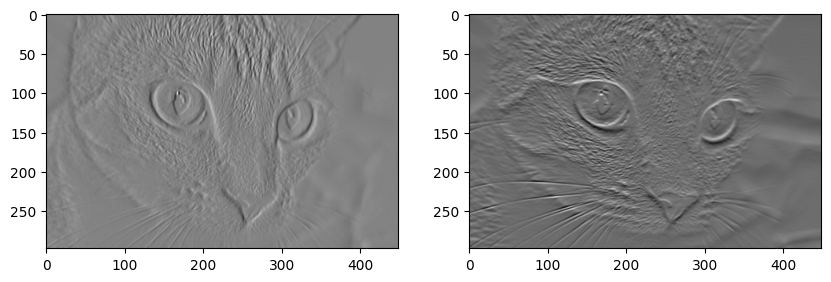

In [33]:
feature_maps = conv(img, l1_filter)

# Plotting the feature maps
plot(feature_maps)

# ReLU Layer

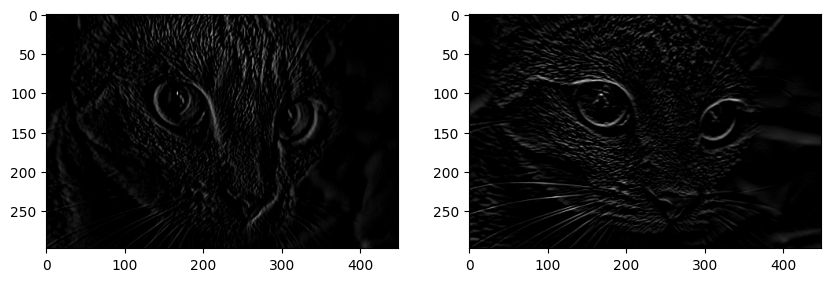

In [34]:
def relu(feature_map):
    """
    Loop through the feature map and if an element is less than zero, change it to zero.
    """
    # output placeholder
    relu_out = np.zeros(feature_map.shape)
    # applying ReLU to each feature map (remember that the last dimension is the number of feature maps (feature map depth). See conv() function)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):  # rows in a feature map
            for c in np.arange(0, feature_map.shape[1]):  # columns in a feature map
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])  # TODO: can we brodcast the max function?
    return relu_out

relu_out = relu(feature_maps)

# Plotting the feature maps
plot(relu_out)

# Max Pooling Layer

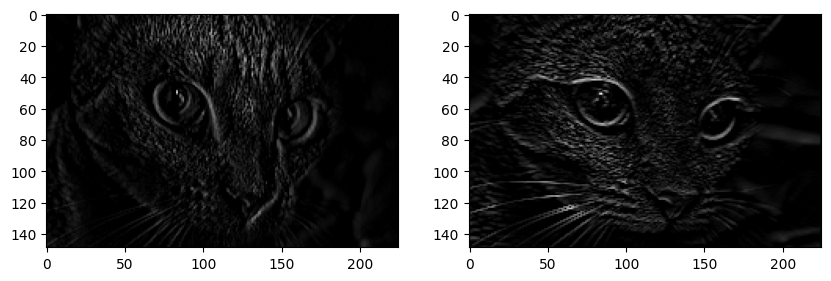

In [37]:
def pooling(feature_map, size=2, stride=2):
    """
    Downsample the image by taking the maximum value of the image in the region represented by the filter.
    """
    # preparing the output of the pooling operation
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                         np.uint16((feature_map.shape[1]-size+1)/stride+1),
                         feature_map.shape[-1]))
    
    # iterate through each feature map in the feature map bank
    for map_num in range(feature_map.shape[-1]):
        # initialize the output's row index
        r2 = 0
        # in here, in contrast to the conv function, r and c refer to the top index at the left corner of the filter and not the center
        for r in np.arange(0,feature_map.shape[0]-size+1, stride):
            # initialize the output's columen index
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1  # increment the output's column index
            r2 = r2 +1  # increment the output's row index
    return pool_out

pool_out = pooling(relu_out)

plot(pool_out)

# Stacking Layers (Building the CNN)

In [38]:
# First conv layer
print("Conv layer 1")
# since we already created the first filter, we skip that step
l1_feature_map = conv(img, l1_filter)
l1_feature_map_relu = relu(l1_feature_map)
l1_feature_map_relu_pool = pooling(l1_feature_map_relu)

# Second conv layer
print("\n*Conv layer 2")
# notice that the depth of the filter is the same as the depth of the feature map, hence the naming.
l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
l2_feature_map_relu = relu(l2_feature_map)
l2_feature_map_relu_pool = pooling(l2_feature_map_relu)

# Third conv layer
print("\n*Conv layer 3")
l3_filter = np.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)
l3_feature_map_relu = relu(l3_feature_map)
l3_feature_map_relu_pool = pooling(l3_feature_map_relu)


Conv layer 1
Filter  1
Filter  2

*Conv layer 2
Filter  1
Filter  2
Filter  3

*Conv layer 3
Filter  1


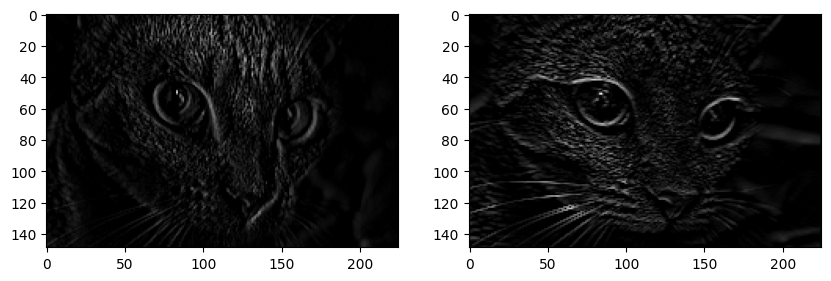

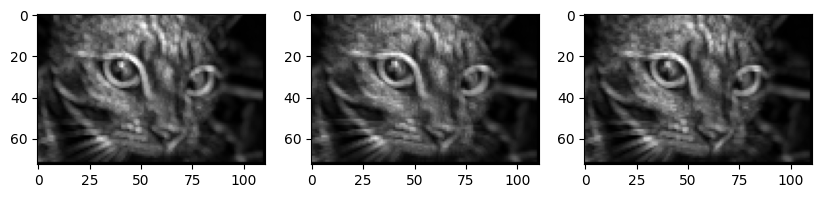

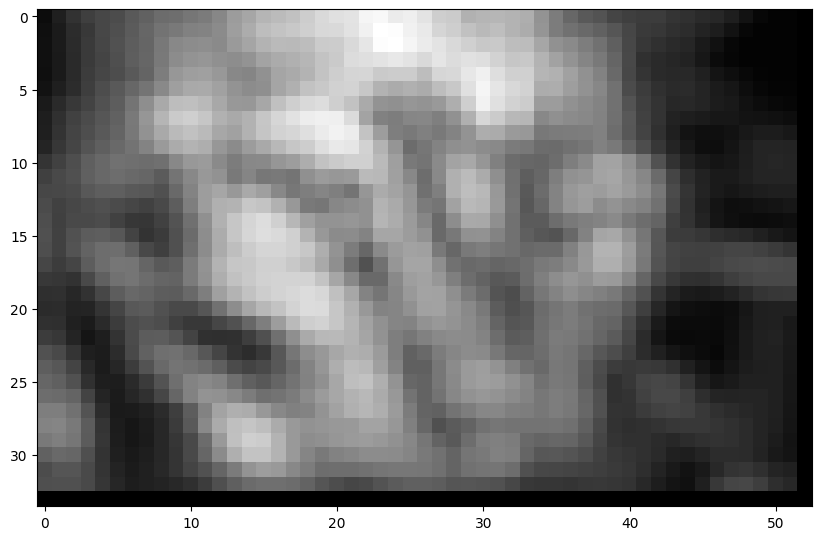

In [43]:
# plot the feature maps
plot(l1_feature_map_relu_pool)
plot(l2_feature_map_relu_pool)
plot(l3_feature_map_relu_pool)